# Import appropriate modules

In [1]:
import numpy as np
from numpy.linalg import eigh
np.set_printoptions(threshold=np.inf, linewidth=np.inf)
np.set_printoptions(formatter={'float': lambda x: "{0:0.3e}".format(x)})

import diatom.hamiltonian as hamiltonian
import diatom.calculate as calculate
from diatom.constants import Rb87Cs133

import scipy.constants

import matplotlib.pyplot as plt
import matplotlib.colors

import mpl_interactions.ipyplot as iplt
from mpl_interactions.controller import Controls

from functools import partial

import itertools

#plt.rcParams["text.usetex"] = True
plt.rcParams["font.family"] = 'sans-serif'
plt.rcParams["figure.autolayout"] = True
plt.rcParams['figure.figsize'] = (4, 3.5)
plt.rcParams['figure.dpi'] = 200

%matplotlib widget
%config InlineBackend.figure_format = 'retina'

# Define 'global' Constants

In [2]:
H_BAR = scipy.constants.hbar

I1 = Rb87Cs133["I1"]
I2 = Rb87Cs133["I2"]
D_0 = Rb87Cs133["d0"]
N_MAX=2

I = 0 #W/m^2
E = 0 #V/m

GAUSS = 1e4 # T
B_MIN = 0.01 / GAUSS # T
B_MAX = 400 / GAUSS # T
B_STEPS = 400

B, B_STEP_SIZE = np.linspace(B_MIN, B_MAX, B_STEPS, retstep=True) #T

PULSE_TIME = 100e-6 # s

def btoi(b):
    return (b-B_MIN)/B_STEP_SIZE

def itob(i):
    return B_STEP_SIZE*i+B_MIN

# Build and Diagonalise Hamiltonian for many B

In [3]:
H0,Hz,Hdc,Hac = hamiltonian.build_hamiltonians(N_MAX, Rb87Cs133, zeeman=True, Edc=True, ac=True)

H = H0[..., None]+\
    Hz[..., None]*B+\
    Hdc[..., None]*E+\
    Hac[..., None]*I
H = H.transpose(2,0,1)

ENERGIES_UNSORTED, STATES_UNSORTED = eigh(H)
N_STATES = len(ENERGIES_UNSORTED[0])

In [4]:
# ENERGIES_HALF_SORTED, STATES_HALF_SORTED = calculate.sort_smooth(ENERGIES_UNSORTED,STATES_UNSORTED)
ENERGIES, STATES, LABELS = calculate.sort_by_state(ENERGIES_UNSORTED, STATES_UNSORTED, N_MAX, Rb87Cs133)

In [5]:
MAGNETIC_MOMENTS = calculate.magnetic_moment(STATES, N_MAX, Rb87Cs133)

In [6]:
dipole_op_zero = calculate.dipole(N_MAX,I1,I2,1,0)
dipole_op_minus = calculate.dipole(N_MAX,I1,I2,1,-1)
dipole_op_plus = calculate.dipole(N_MAX,I1,I2,1,+1)

COUPLINGS_ZERO = STATES[:, :, :].conj().transpose(0, 2, 1) @ (dipole_op_zero @ STATES[:, :, :])
COUPLINGS_MINUS = STATES[:, :, :].conj().transpose(0, 2, 1) @ (dipole_op_minus @ STATES[:, :, :])
COUPLINGS_PLUS = STATES[:, :, :].conj().transpose(0, 2, 1) @ (dipole_op_plus @ STATES[:, :, :])

COUPLINGS = [COUPLINGS_ZERO,COUPLINGS_PLUS,COUPLINGS_MINUS]

# Helper Functions

In [7]:
def label_to_state_no(N,MF,k):
    for i, label in enumerate(LABELS):
        if label[0] == N and label[1] == MF and label[2] == k:
            return i

def state_no_to_uncoupled_label(state_no):
    i=0
    I1d = int(I1*2)
    I2d = int(I2*2)
    for n in range(0, N_MAX + 1):
        for mn in range(n,-(n+1),-1):
            for mi1 in range(I1d,-I1d-1,-2):
                for mi2 in range(I2d,-I2d-1,-2):
                    if i == state_no:
                        return (n,mn,mi1/2,mi2/2)
                    i+=1
    
print(label_to_state_no(*(2, 4, 13)))

None


In [8]:
def twice_average_fidelity(k,g):
    return ((1 + g**2)**2 + 8*k**2*(-1 + 2*g**2) + 16*k**4)/((1 + g**2)**3 + (-8 + 20*g**2 + g**4)*k**2 + 16*k**4)

def maximum_fidelity(k,g):
    phi = np.arccos((k*(18-9*g**2-8*k**2))/(3+3*g**2+4*k**2)**(3/2))/3
    denominator = 54*((1+g**2)**3+(-8+20*g**2+g**4)*k**2+16*k**4)
    numerator = (
                 36*(g**4+(1-4*k**2)**2+2*g**2*(1+8*k**2))
               + 32*k    *(3+3*g**2+4*k**2)**(3/2) *np.cos(phi)
               - 64*k**2 *(3+3*g**2+4*k**2)        *np.cos(2*phi) 
               -  4      *(3+3*g**2+4*k**2)**2     *np.cos(4*phi)
                )
    return numerator/denominator

In [9]:
def trio_transfer_efficiency(state1_label,state2_label,state3_label,bi,pulse_time=0.0001):
    state1i = label_to_state_no(*state1_label)
    state2i = label_to_state_no(*state2_label)
    state3i = label_to_state_no(*state3_label)
    
    P = state1_label[1] - state2_label[1]
    COUPLING = COUPLINGS[P]
    
    g = np.abs(COUPLING[bi, state1i, state3i]/COUPLING[bi, state1i, state2i])
    k = np.abs(((ENERGIES[bi, state3i] - ENERGIES[bi, state2i]) / scipy.constants.h) / (1/pulse_time))
    sub_transfered = maximum_fidelity(k,g)
    
    return sub_transfered

In [10]:
def transfer_efficiency(state1_label, state2_label,bi,pulse_time=0.0001):
    transfered = 1
    
    state1i = label_to_state_no(*state1_label)
    state2i = label_to_state_no(*state2_label)

    P = (state1_label[1] - state2_label[1])*(state2_label[0] - state1_label[0])
    COUPLING = COUPLINGS[P]
    
    for state3i in range(N_STATES):
        if state3i == state1i or state3i == state2i:
            continue
        g = np.abs(COUPLING[bi, state1i, state3i]/COUPLING[bi, state1i, state2i])
        k = np.abs(((ENERGIES[bi, state3i] - ENERGIES[bi, state2i]) / scipy.constants.h) / (1/pulse_time))
        sub_transfered = maximum_fidelity(k,g)
        transfered *= sub_transfered
        
    return transfered

In [11]:
print(transfer_efficiency((0,5,0),(1,4,1),int(B_STEPS/2)))
print(transfer_efficiency((1,4,1),(0,5,0),int(B_STEPS/2)))
print('----')
print(transfer_efficiency((0,5,0),(1,5,1),int(B_STEPS/2)))
print(transfer_efficiency((1,5,1),(0,5,0),int(B_STEPS/2)))
print('----')
print(transfer_efficiency((0,5,0),(1,6,0),int(B_STEPS/2)))
print(transfer_efficiency((1,6,0),(0,5,0),int(B_STEPS/2)))
print('---------')
print(transfer_efficiency((0,4,1),(1,3,1),int(B_STEPS/2)))
print(transfer_efficiency((1,3,1),(2,2,0),int(B_STEPS/2)))
print(transfer_efficiency((2,2,0),(1,3,0),int(B_STEPS/2)))
print(transfer_efficiency((1,3,0),(0,4,1),int(B_STEPS/2)))
print(transfer_efficiency((0,4,1),(1,3,0),int(B_STEPS/2)))
print('-----------------')
# (0,4,1),(1,4,5),(2,4,0),(1,4,0)
print(transfer_efficiency((0,4,1),(1,4,5),int(65)))
print(transfer_efficiency((1,4,5),(2,4,2),int(65)))
print(transfer_efficiency((2,4,2),(1,4,1),int(65)))
print(transfer_efficiency((1,4,1),(0,4,1),int(65)))

0.9843816778828208
0.9999999999920327
----
0.9301643702206602
0.9999999998601394
----
0.999999999998943
0.9999999999954984
---------
0.5159644229396513
0.9394170274057085
0.9981558752646578
0.08596315271060782
0.01677283851132005
-----------------
0.9940500294484975
0.7570734361945248
0.9999227765252104
0.9978399209474262


0.9999999999996989


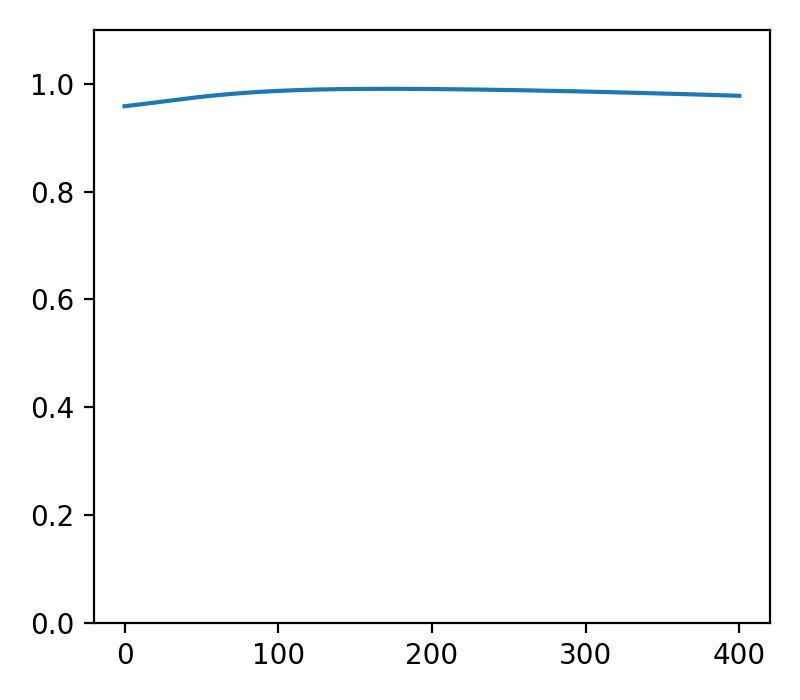

In [12]:
print(transfer_efficiency((0,5,0),(1,6,0),int(B_STEPS-1)))

eff = []
for bi in range(B_STEPS):
    eff.append(transfer_efficiency((0,5,0),(1,5,2),bi))
eff=np.array(eff)
fig,ax=plt.subplots()
ax.set_ylim(0,1.1)
ax.plot(B*GAUSS,eff)

# General Constants

In [13]:
INITIAL_STATE_LABEL = (0,5,0)
INITIAL_STATE_POSITION = label_to_state_no(*INITIAL_STATE_LABEL)

# Ordered by energy low->high at 181.5G 
ACCESSIBLE_STATE_LABELS = [(1, 5, 0), (1, 4, 0), (1, 4, 1), (1, 6, 0), (1, 5, 1), (1, 4, 2), (1, 5, 2), (1, 4, 3), (1, 4, 4), (1, 4, 5)]
ACCESSIBLE_STATE_POSITIONS = [label_to_state_no(N,MF,k) for N,MF,k in ACCESSIBLE_STATE_LABELS]

CONSIDERED_STATE_LABELS = [INITIAL_STATE_LABEL] + ACCESSIBLE_STATE_LABELS
CONSIDERED_STATE_POSITIONS = [INITIAL_STATE_POSITION] + ACCESSIBLE_STATE_POSITIONS

STATE_CMAP = plt.cm.gist_rainbow(np.linspace(0,1,len(CONSIDERED_STATE_POSITIONS)))

# Debug sort function Find Magnetic Moments

/Users/tom/Code/project/diatom-notebooks/venv/lib/python3.10/site-packages/matplotlib/cbook/__init__.py:1369: ComplexWarning: Casting complex values to real discards the imaginary part
  return np.asarray(x, float)


Text(0.5, 0, 'Magnetic Field $B_z$ (G)')

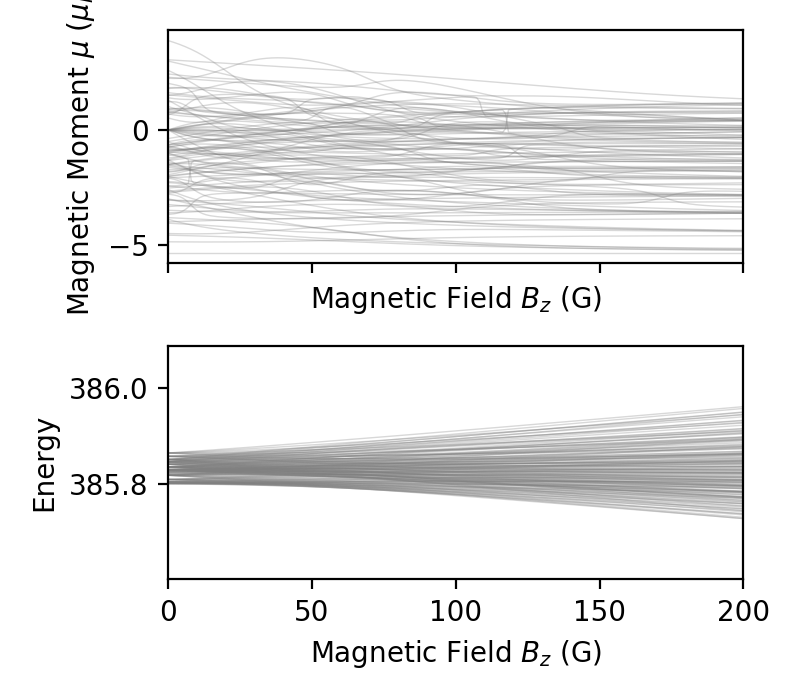

In [14]:
fig, (ax1,ax2) = plt.subplots(2,1,sharex=True)
muN = scipy.constants.physical_constants['nuclear magneton'][0]

ax1.plot(B*GAUSS,MAGNETIC_MOMENTS[:,180:]/muN, color='grey', alpha=0.3,linewidth=0.5,zorder=0);
ax1.set_xlim(0,200)
ax1.set_ylabel("Magnetic Moment $\mu$ $(\mu_N)$")
ax1.set_xlabel("Magnetic Field $B_z$ (G)")

ax2.plot(B*GAUSS,ENERGIES[:,128:]/muN, color='grey', alpha=0.3,linewidth=0.5,zorder=0);
ax2.set_xlim(0,200)
ax2.set_ylabel("Energy")
ax2.set_xlabel("Magnetic Field $B_z$ (G)")



# Find Coindidences

In [15]:
def label_degeneracy(N,MF):
    # Want number of ways of having
    # MF = MN + (M_I1 + M_I2) # NP-Hard Problem SSP (Subset Sum)
    d=0
    for MN in range(-N,N+1):
        for M_I1 in range(-int(I1+0.5),int(I1+0.5)+1):
            M_I1 = M_I1-0.5
            for M_I2 in range(-int(I2+0.5),int(I2+0.5)+1):
                M_I2 = M_I2-0.5
                if MN+M_I1+M_I2 == MF:
                    d+=1
    return d

print(label_degeneracy(0,5))
print(label_degeneracy(1,4))
print(label_degeneracy(1,5))
print(label_degeneracy(1,6))
print(label_degeneracy(1,7))

1
6
3
1
0


In [16]:
# Find all possible combinations
base_mf = 4
polarisations = []
for p1 in [-1,0,1]:
    for p2 in [-1,0,1]:
        for p3 in [-1,0,1]:
            for p4 in [-1,0,1]:
                if p1+p2+p3+p4 == 0:
                    polarisations.append((p1,p2,p3,p4))

state_mfs = [(base_mf,base_mf+p1,base_mf+p1+p2,base_mf+p1+p2+p3) for p1,p2,p3,_ in polarisations]

states = []

for state_mf in state_mfs:
    for i in [1]:
        for j in range(label_degeneracy(1,state_mf[1])):
            for k in range(label_degeneracy(2,state_mf[2])):
                for l in range(label_degeneracy(1,state_mf[3])):
                    if (state_mf[1]<state_mf[3]) or (state_mf[1]==state_mf[3] and j<=l):
                        continue
                    states.append([(0,state_mf[0],i),(1,state_mf[1],j),(2,state_mf[2],k),(1,state_mf[3],l)])
                    
states=np.array(states)
                    
print(len(states), "states to consider")

4014 states to consider


In [17]:
# Find best B for minimum dipole deviation
best_deviation = np.ones((len(states)),dtype=np.double)
best_b_index = np.ones((len(states)),dtype=int)
for i,state_posibility in enumerate(states):
    desired_indices = np.array([
        label_to_state_no(*state_posibility[0]),
        label_to_state_no(*state_posibility[1]),
        label_to_state_no(*state_posibility[2]),
        label_to_state_no(*state_posibility[3])
    ])
    if desired_indices.all() != None:
        all_moments = MAGNETIC_MOMENTS[:,desired_indices]
        max_moment = np.amax(all_moments,axis=1)
        min_moment = np.amin(all_moments,axis=1)
        deviation = max_moment - min_moment
        
    min_diff_loc = np.argmin(deviation)
    min_diff = deviation[min_diff_loc]

    best_deviation[i] = np.abs(min_diff)
    best_b_index[i] = min_diff_loc

In [26]:
# Simulate microwave transfers to find 'fidelity'
top_fidelities = np.zeros(len(states),dtype=np.double)
desired_pulse_time = 5000 * 1e-6 # microseconds, longer => increased fidelity
for i, focus_state in enumerate(states):
    at_Bi = best_b_index[i]
    p = 1
    for fi in range(4):
        state_a_label = focus_state[fi%4]
        state_b_label = focus_state[(fi+1)%4]
        if (label_to_state_no(*state_a_label) is None) or (label_to_state_no(*state_b_label) is None):
            p*=0
        else:
            up_efficiency = transfer_efficiency(state_a_label,state_b_label,at_Bi,pulse_time=desired_pulse_time)
            down_efficiency = transfer_efficiency(state_b_label,state_a_label,at_Bi,pulse_time=desired_pulse_time)
            p *= up_efficiency * down_efficiency
        # print(p)
        # print(state_a_label,'->', state_b_label,'efficiency:', efficiency)
    top_fidelities[i] = p

In [27]:
# Rank state combinations
rating = np.zeros(len(states),dtype=np.double)
bestest_deviation = np.max(best_deviation)
bestest_fidelity = np.max(top_fidelities)
for i, focus_state in enumerate(states):
    deviation = bestest_deviation/best_deviation[i]
    fidelity = top_fidelities[i]
    rating[i] = deviation#*fidelity

order = (-rating).argsort()

/Users/tom/Code/project/diatom-notebooks/venv/lib/python3.10/site-packages/matplotlib/cbook/__init__.py:1369: ComplexWarning: Casting complex values to real discards the imaginary part
  return np.asarray(x, float)


f 0.6636719881525414 bi 152
f 0.7808206595213494 bi 150
f 0.8989580272467959 bi 68
f 0.9999999150159993 bi 367
f 0.999999965452803 bi 399
f 0.9999999715093879 bi 399
f 0.9998112962388771 bi 65
f 0.9999999648216608 bi 399
f 0.6141552274141321 bi 78
f 6.227180400593102e-07 bi 80
f 0.9999999830409319 bi 399
f 0.043591062245689795 bi 84
f 0.7427753890721283 bi 84
f 0.8058554514295092 bi 80
f 0.9864837695343545 bi 71
f 0.016578523127939334 bi 186
f 0.9999802705401784 bi 218
f 0.999988078665586 bi 218
f 0.024360844290165776 bi 180
f 0.9556659832417398 bi 180
f 0.00022427873851594982 bi 231
f 0.0006420699570028939 bi 231
f 0.9897345340392951 bi 211
f 0.0006759475517566953 bi 231
f 0.6516574747407663 bi 76


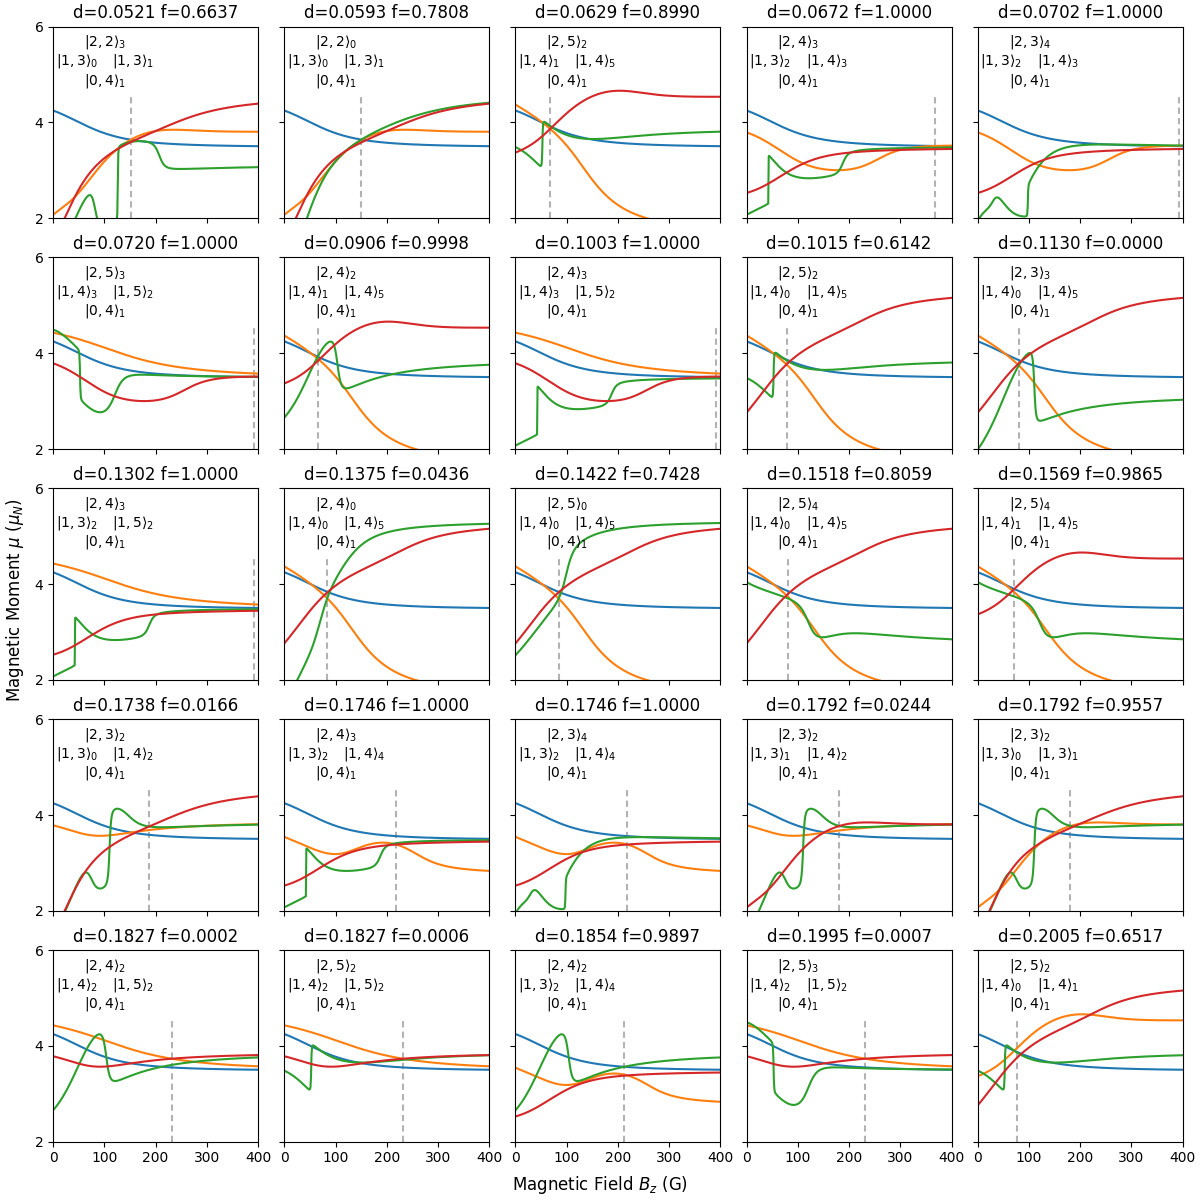

In [28]:
fig, axs = plt.subplots(5,5,figsize=(12,12),dpi=100,sharex=True,sharey=True,constrained_layout=True)

ordered_states = states[order]
ordered_B = best_b_index[order]
ordered_fidelities = top_fidelities[order]
ordered_deviations = best_deviation[order]

i=0
for axh in axs:
    for ax in axh:
        state_labels = ordered_states[i]
        state_numbers = np.array([label_to_state_no(*state_label) for state_label in ordered_states[i]])
        ax.set_xlim(0,B_MAX*GAUSS)
        ax.set_ylim(2,6)
        ax.set_xticks([0, 100, 200, 300, 400])
        ax.set_yticks([2, 4, 6])
        ax.plot(B*GAUSS,MAGNETIC_MOMENTS[:,state_numbers]/muN, alpha=1,linewidth=1.5,zorder=1);
        ax.axvline(x=min(B[ordered_B[i]]*GAUSS,B_MAX*GAUSS*0.98), dashes=(3, 2), color='k', linewidth=1.5,alpha=0.3,zorder=0,ymax=0.65)
        fidelity = ordered_fidelities[i]
        print("f",fidelity,"bi",ordered_B[i])
        max_dev = np.abs(ordered_deviations[i]/muN)
        ax.set_title(f'd={max_dev:.4f} f={fidelity:.4f}')
        ax.text(60,4.8,r'$|{},{}\rangle_{}$'.format(*(state_labels[0])))
        ax.text(115,5.2,r'$|{},{}\rangle_{}$'.format(*(state_labels[1])))
        ax.text(60,5.6,r'$|{},{}\rangle_{}$'.format(*(state_labels[2])))
        ax.text(5,5.2,r'$|{},{}\rangle_{}$'.format(*(state_labels[3])))
        i+=1

fig.supxlabel( 'Magnetic Field $B_z$ (G)')
fig.supylabel('Magnetic Moment $\mu$ $(\mu_N)$')

fig.savefig('../images/magnetic-dipole-coincides.pdf')

# Simulate synthetic dimension for all states

In [61]:
chosen_states = np.array([(0,4,1),(1,4,5),(2,4,2),(1,4,1)])
chosen_states_indices = np.array([label_to_state_no(*label) for label in chosen_states])
chosen_bi = 65
T_STEPS =  [195931,65519,21319,9391][0]
chosen_pulse_time = 5000 * 1e-6
TIME = chosen_pulse_time*20

# Get Angular Frequency Matrix Diagonal for each B
angular = ENERGIES[chosen_bi, :].real / H_BAR # [state]

# Get driving frequencies
chosen_states_angular = angular[chosen_states_indices]
driving = np.array([chosen_states_angular[1]-chosen_states_angular[0],
                    chosen_states_angular[2]-chosen_states_angular[1],
                    chosen_states_angular[2]-chosen_states_angular[3],
                    chosen_states_angular[3]-chosen_states_angular[0]])


# Get desired E field for each B and rabi frequency 
chosen_state_couplings = np.array([
                          COUPLINGS_ZERO[chosen_bi, chosen_states_indices[0], chosen_states_indices[1]],
                          COUPLINGS_ZERO[chosen_bi, chosen_states_indices[1], chosen_states_indices[2]],
                          COUPLINGS_ZERO[chosen_bi, chosen_states_indices[2], chosen_states_indices[3]],
                          COUPLINGS_ZERO[chosen_bi, chosen_states_indices[3], chosen_states_indices[0]]
                         ])
E_i = (2*np.pi*H_BAR) / (D_0 * chosen_state_couplings * chosen_pulse_time)

# Construct times
times, DT = np.linspace(0,TIME,num=T_STEPS,retstep=True)
print(2*np.pi/driving)
print(DT)

# Construct 'kinetic' time step operator (Matrix Diagonal)
print('this:')
print(angular[chosen_states_indices])
T_OP_DIAG = np.exp(-(1j) * angular * DT/2 )

# Construct potential fixed part time step operator 
ORDER = 6

# THIS_COUPLING = STATES[chosen_bi, :, :].conj().transpose(1,0) @ (dipole_op_zero @ STATES[chosen_bi, :, :])
print()
V_TI_M = (-(1j)*D_0*COUPLINGS_ZERO[chosen_bi,:,:]*DT)/H_BAR
print(V_TI_M.shape)
V_TI_M_POWS = np.array([np.linalg.matrix_power(V_TI_M, i)/np.math.factorial(i) for i in range(ORDER)])

# Construct state vector
state_vector = np.zeros((T_STEPS,N_STATES), dtype=np.cdouble)
state_vector[0,chosen_states_indices[0]] = np.sqrt(1)
# state_vector[0,1] = np.sqrt(0.5-0.4)
# state_vector[0,chosen_states_indices[1]] = 1/np.sqrt(4)
# state_vector[0,chosen_states_indices[2]] = 1/np.sqrt(4)
# state_vector[0,chosen_states_indices[3]] = 1/np.sqrt(4)

#path = np.einsum_path('ij,i->j',V_TI_M, state_vector, optimize='optimal')[0]
for t_num in range(T_STEPS-1):
    V_TD = np.sum(E_i*np.cos(driving*times[t_num]))
    V_TD_POWS = V_TD**(np.arange(ORDER))
    V_OP = np.sum(V_TI_M_POWS*V_TD_POWS[:,None,None],axis=0)

    DU = T_OP_DIAG[:,None] * V_OP[:,:] * T_OP_DIAG[None,:]
    state_vector[t_num+1] = DU @ state_vector[t_num] #np.einsum('ij,i->j',DU,state_vector[t_num], optimize=path)
    
    
probabilities = np.abs(state_vector)**2

[1.020e-09 5.101e-10 5.100e-10 1.020e-09]
5.103863624763946e-07
this:
[-6.504e+05 6.160e+09 1.848e+10 6.158e+09]

(288, 288)


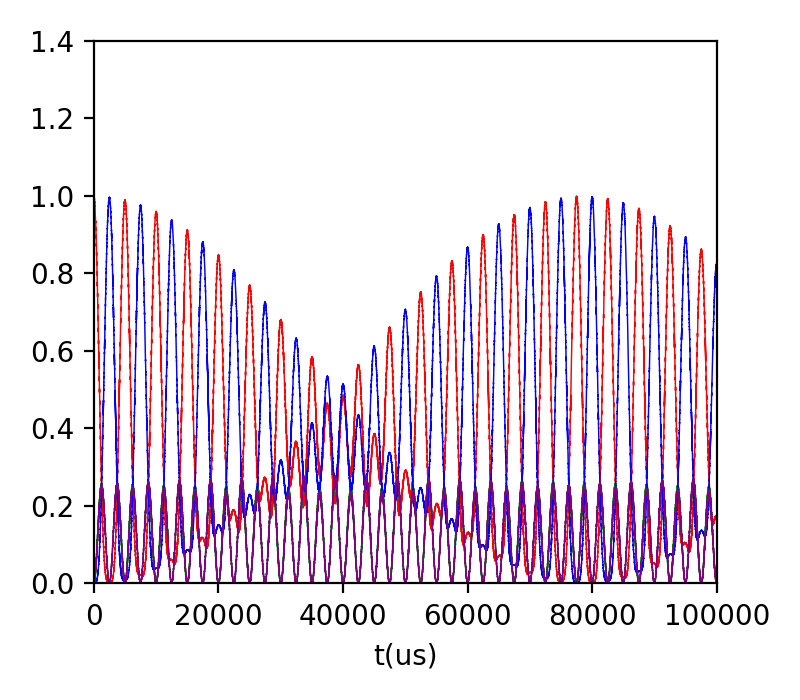

In [62]:
fig,ax = plt.subplots()
ax.set_xlabel('t(us)')
ax.set_ylim(0,1.4)
ax.set_xlim(0,TIME*1e6)
c = ['red','green','blue','purple']
ax.plot(times*1e6,probabilities[:,:],c='grey',linewidth=0.5,alpha=0.3);
i=0
for state_index in chosen_states_indices:
    ax.plot(times*1e6,probabilities[:,state_index],c=c[i],linewidth=0.5);
    i+=1

# Simulate for just these 4-states

In [59]:
chosen_states = np.array([(0,4,1),(1,4,5),(1,4,1),(2,4,2)])
chosen_states_indices = np.array([label_to_state_no(*label) for label in chosen_states])
chosen_bi = 65
T_STEPS =  [1559310,65519,21319,9391][0]
chosen_pulse_time = 1000 * 1e-6
TIME = chosen_pulse_time*5

# Get Angular Frequency Matrix Diagonal for each B
angular = ENERGIES[chosen_bi, :].real / H_BAR
# angular[chosen_states_indices[1]]+=1e8

# Get driving frequencies
chosen_states_angular = angular[chosen_states_indices]
driving = np.array([chosen_states_angular[1]-chosen_states_angular[0],
                    chosen_states_angular[2]-chosen_states_angular[0],
                    chosen_states_angular[3]-chosen_states_angular[1],
                    chosen_states_angular[3]-chosen_states_angular[2]])

# Get desired E field for each B and rabi frequency 
chosen_state_couplings = np.array([
                          COUPLINGS_ZERO[chosen_bi, chosen_states_indices[1], chosen_states_indices[0]],
                          COUPLINGS_ZERO[chosen_bi, chosen_states_indices[2], chosen_states_indices[0]],
                          COUPLINGS_ZERO[chosen_bi, chosen_states_indices[3], chosen_states_indices[1]],
                          COUPLINGS_ZERO[chosen_bi, chosen_states_indices[3], chosen_states_indices[2]]
                         ])
E_i = (2*np.pi*H_BAR) / (D_0 * chosen_state_couplings * chosen_pulse_time)

# Construct times
times, DT = np.linspace(0,TIME,num=T_STEPS,retstep=True)
print("drivePeriods:",2*np.pi/driving,"timeStep:",DT)

# Construct 'kinetic' time step operator (Matrix Diagonal)
T_OP_DIAG = np.exp(-(1j) * angular[chosen_states_indices] * DT/2 )

# Construct potential fixed part time step operator 
ORDER = 10

THIS_COUPLING = STATES[chosen_bi, :, chosen_states_indices].conj() @ (dipole_op_zero @ STATES[chosen_bi, :, chosen_states_indices].transpose(1, 0))
V_TI_M = (-(1j)*D_0*THIS_COUPLING*DT)/H_BAR
V_TI_M_POWS = np.array([np.linalg.matrix_power(V_TI_M, i)/np.math.factorial(i) for i in range(ORDER)])

# Construct state vector
state_vector = np.zeros((T_STEPS,4), dtype=np.cdouble)
state_vector[0,0] = np.sqrt(1)

#path = np.einsum_path('ij,i->j',V_TI_M, state_vector, optimize='optimal')[0]
for t_num in range(T_STEPS-1):
    V_TD = np.sum(E_i*np.cos(driving*times[t_num]))
    V_TD_POWS = V_TD**(np.arange(ORDER))
    V_OP = np.sum(V_TI_M_POWS*V_TD_POWS[:,None,None],axis=0)

    DU = T_OP_DIAG[:,None] * V_OP[:,:] * T_OP_DIAG[None,:]
    state_vector[t_num+1] = DU @ state_vector[t_num] #np.einsum('ij,i->j',DU,state_vector[t_num], optimize=path)
    
probabilities = np.abs(state_vector)**2

[-6.504e+05 6.160e+09 6.158e+09 1.848e+10]
drivePeriods: [1.020e-09 1.020e-09 5.101e-10 5.100e-10] timeStep: 3.2065485416937888e-09


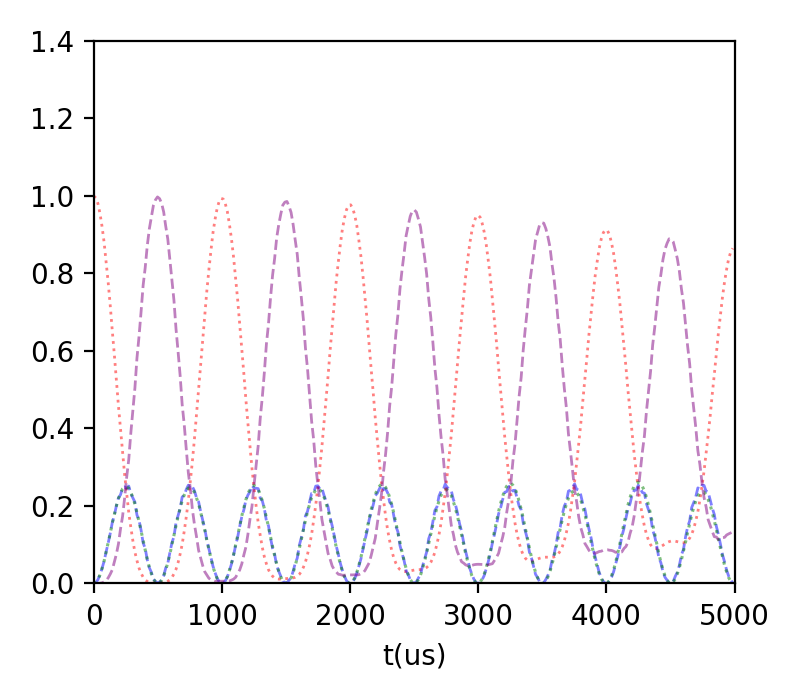

In [60]:
fig,ax = plt.subplots()
ax.set_xlabel('t(us)')
ax.set_ylim(0,1.4)
ax.set_xlim(0,TIME*1e6)
c = ['red','green','blue','purple']

skip=5000
ax.plot(times[::skip]*1e6,probabilities[::skip,0],c='red',linewidth=1,alpha=0.5,linestyle='dotted');
ax.plot(times[::skip]*1e6,probabilities[::skip,2],c='blue',linewidth=1,alpha=0.5,linestyle='dashed');
ax.plot(times[::skip]*1e6,probabilities[::skip,1],c='green',linewidth=1.1,alpha=0.5,linestyle='dotted');
ax.plot(times[::skip]*1e6,probabilities[::skip,3],c='purple',linewidth=1,alpha=0.5,linestyle='dashed');

# 4-state ideal

In [56]:
T_STEPS =  [1959310,65519,21319,9391][0]
chosen_pulse_time = 100000 * 1e-6
TIME = chosen_pulse_time*3

# Get Angular Frequency Matrix Diagonal for each B
angular = 1e6*np.array([0, 0.4, 0.7, 1]) # [state]

coupling = np.array(
[[ 0, 0.3,  0.25, 0],
 [0.3,  0, 0,  0.05],
 [ 0.25, 0, 0,  0.6],
 [ 0,  0.05,  0.6, 0]]
)

# Get driving frequencies
driving = np.array([angular[1]-angular[0],
                    angular[2]-angular[0],
                    angular[3]-angular[1],
                    angular[3]-angular[2]])



# Get desired E field for each B and rabi frequency 
chosen_state_couplings = np.array([
                          coupling[1,0],
                          coupling[2,0],
                          coupling[3,1],
                          coupling[3,2]
                         ])
E_i = (2*np.pi*H_BAR) / (D_0 * chosen_state_couplings * chosen_pulse_time)


# Construct times
times, DT = np.linspace(0,TIME,num=T_STEPS,retstep=True)
print(2*np.pi/driving)
print(DT)

# Construct 'kinetic' time step operator (Matrix Diagonal)
T_OP_DIAG = np.exp(-(1j) * angular * DT/2 )

# Construct potential fixed part time step operator 
ORDER = 6

V_TI_M = (-(1j)*D_0*coupling*DT)/H_BAR
print(V_TI_M.shape)
V_TI_M_POWS = np.array([np.linalg.matrix_power(V_TI_M, i)/np.math.factorial(i) for i in range(ORDER)])

# Construct state vector
state_vector = np.zeros((T_STEPS,4), dtype=np.cdouble)
state_vector[0,0] = np.sqrt(1)
# state_vector[0,1] = np.sqrt(0.5-0.4)
# state_vector[0,chosen_states_indices[1]] = 1/np.sqrt(4)
# state_vector[0,chosen_states_indices[2]] = 1/np.sqrt(4)
# state_vector[0,chosen_states_indices[3]] = 1/np.sqrt(4)

#path = np.einsum_path('ij,i->j',V_TI_M, state_vector, optimize='optimal')[0]
for t_num in range(T_STEPS-1):
    V_TD = np.sum(E_i*np.cos(driving*times[t_num]))
    V_TD_POWS = V_TD**(np.arange(ORDER))
    V_OP = np.sum(V_TI_M_POWS*V_TD_POWS[:,None,None],axis=0)

    DU = T_OP_DIAG[:,None] * V_OP[:,:] * T_OP_DIAG[None,:]
    state_vector[t_num+1] = DU @ state_vector[t_num] #np.einsum('ij,i->j',DU,state_vector[t_num], optimize=path)
    
    
probabilities = np.abs(state_vector)**2

[1.571e-05 8.976e-06 1.047e-05 2.094e-05]
1.531152054117038e-07
(4, 4)


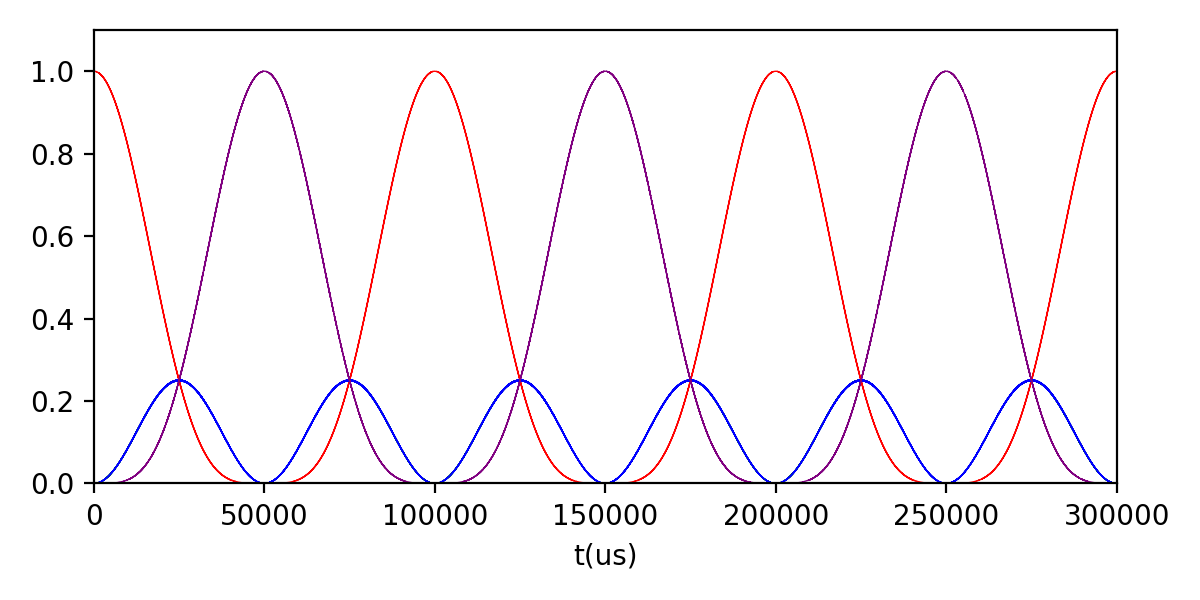

In [57]:
fig,ax = plt.subplots(figsize=(6,3))
ax.set_xlabel('t(us)')
ax.set_ylim(0,1.1)
ax.set_xlim(0,TIME*1e6)
c = ['red','green','blue','purple']
# ax.plot(times*1e6,probabilities[:,:],c='grey',linewidth=0.5,alpha=0.3);
i=0
for state_index in range(4):
    ax.plot(times*1e6,probabilities[:,state_index],c=c[i],linewidth=0.5);
    i+=1